# XAI Project
### NAME     --           ID
### Surafel Sentayehu       --         GSR/5928/17
### Kirubel Sentayehu -- GSR/7879/17
### Michael Shimeles         --       GSR/6484/17



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pdpbox
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e3a6c8bdf6c999060bd4bbc9648ccdf305e089ec6e9ef53033a057aaea7e140f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, confusion_matrix, classification_report
)

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# XAI libraries
import shap
from lime import lime_tabular
from pdpbox import pdp

# Set random seed and style
np.random.seed(42)
# wanted to use Seaborn's default style, this line is usually not needed,
# wanted a specific Seaborn style, use:
sns.set_style('darkgrid')  # or 'whitegrid', 'ticks', 'poster'
sns.set_palette('husl')

In [ ]:
# Load only the training dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/cs-training.csv', index_col=0)

print("Dataset Shape:", df.shape)
print("\nFeatures:\n", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (150000, 11)

Features:
 ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

Missing Values:
 SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


# Target Variable Analysis

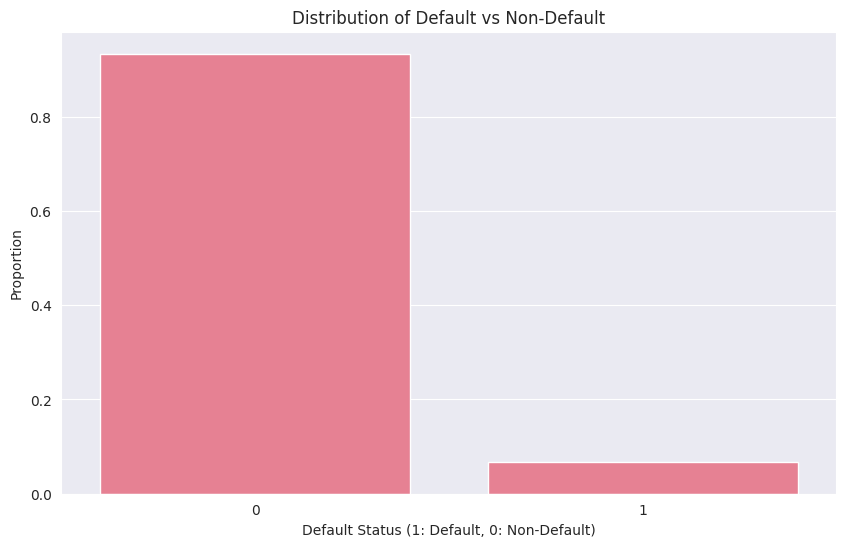


Class Distribution:
SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(10, 6))
target_dist = df['SeriousDlqin2yrs'].value_counts(normalize=True)
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Distribution of Default vs Non-Default')
plt.xlabel('Default Status (1: Default, 0: Non-Default)')
plt.ylabel('Proportion')
plt.show()

print("\nClass Distribution:")
print(df['SeriousDlqin2yrs'].value_counts(normalize=True))

**This significant class imbalance is actually quite typical for credit default datasets, as defaults are relatively rare events**

# Correlation Analysis

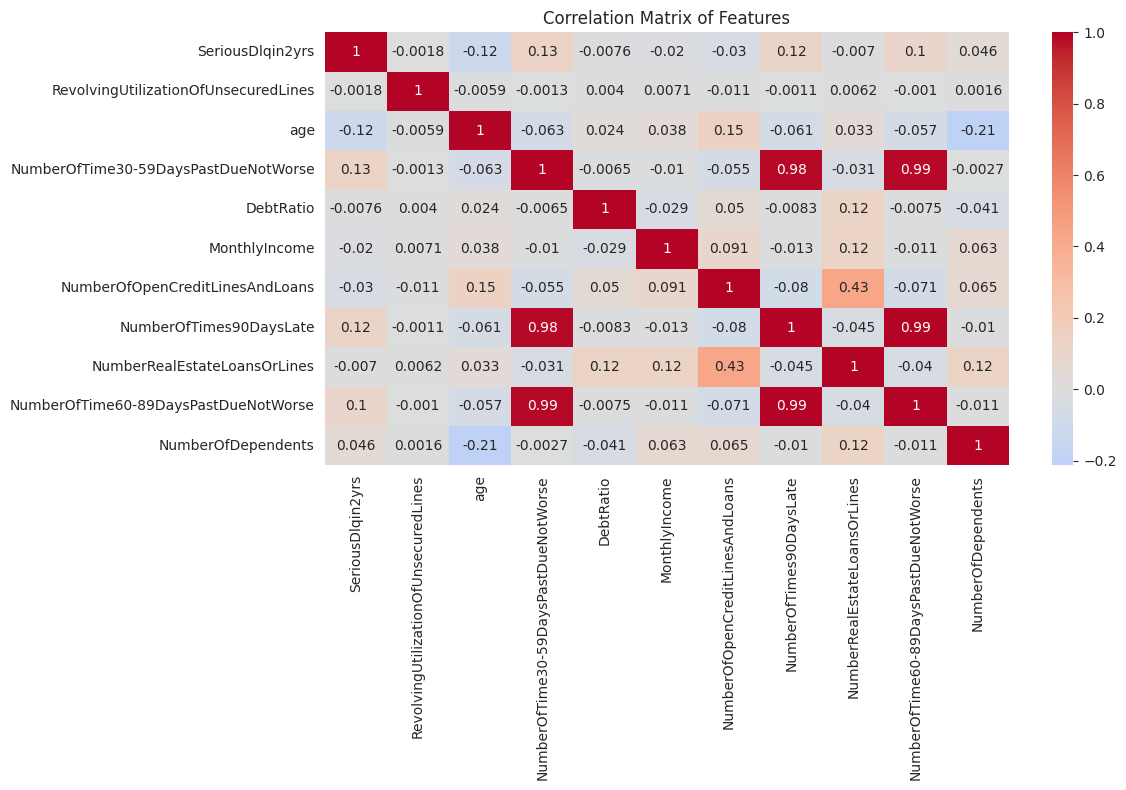

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

## Correlation Analysis Findings:
Very strong correlations (0.98-0.99) between different payment delay features:

NumberOfTime30-59DaysPastDueNotWorse <br>

NumberOfTimes90DaysLate<br>

NumberOfTime60-89DaysPastDueNotWorse<br>

Moderate correlation (0.43) between NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines<br>

Age has a slight negative correlation (-0.12) with default risk
Most other features show weak correlations with the target variable

# Missing Values Analysis

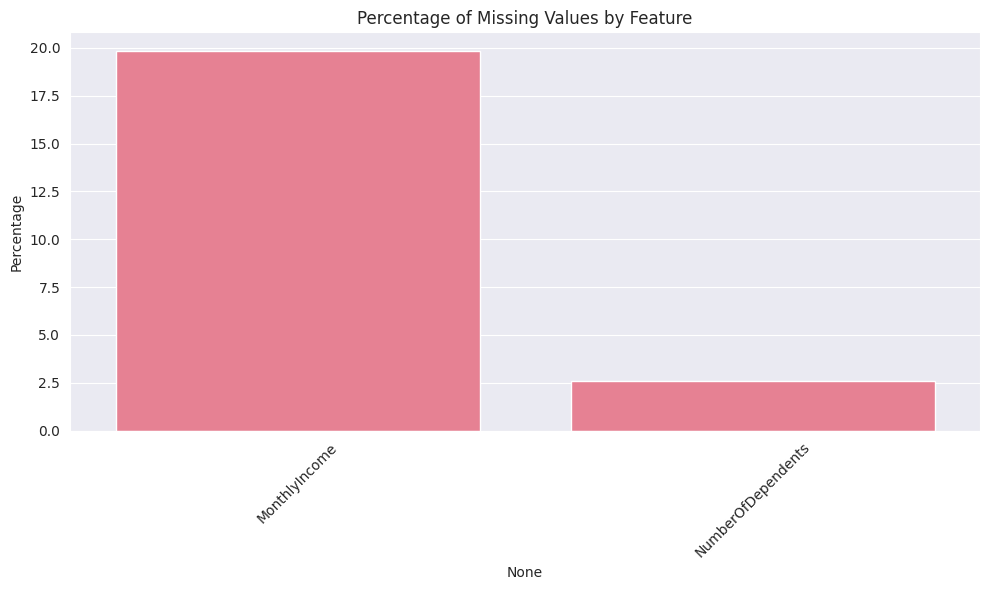

In [ ]:
key_features = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfTimes90DaysLate'
]

plt.figure(figsize=(10, 6))
missing_values = df.isnull().sum() / len(df) * 100
missing_values = missing_values[missing_values > 0]
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.title('Percentage of Missing Values by Feature')
plt.xticks(rotation=45)
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

# Box Plots for Outlier Detection

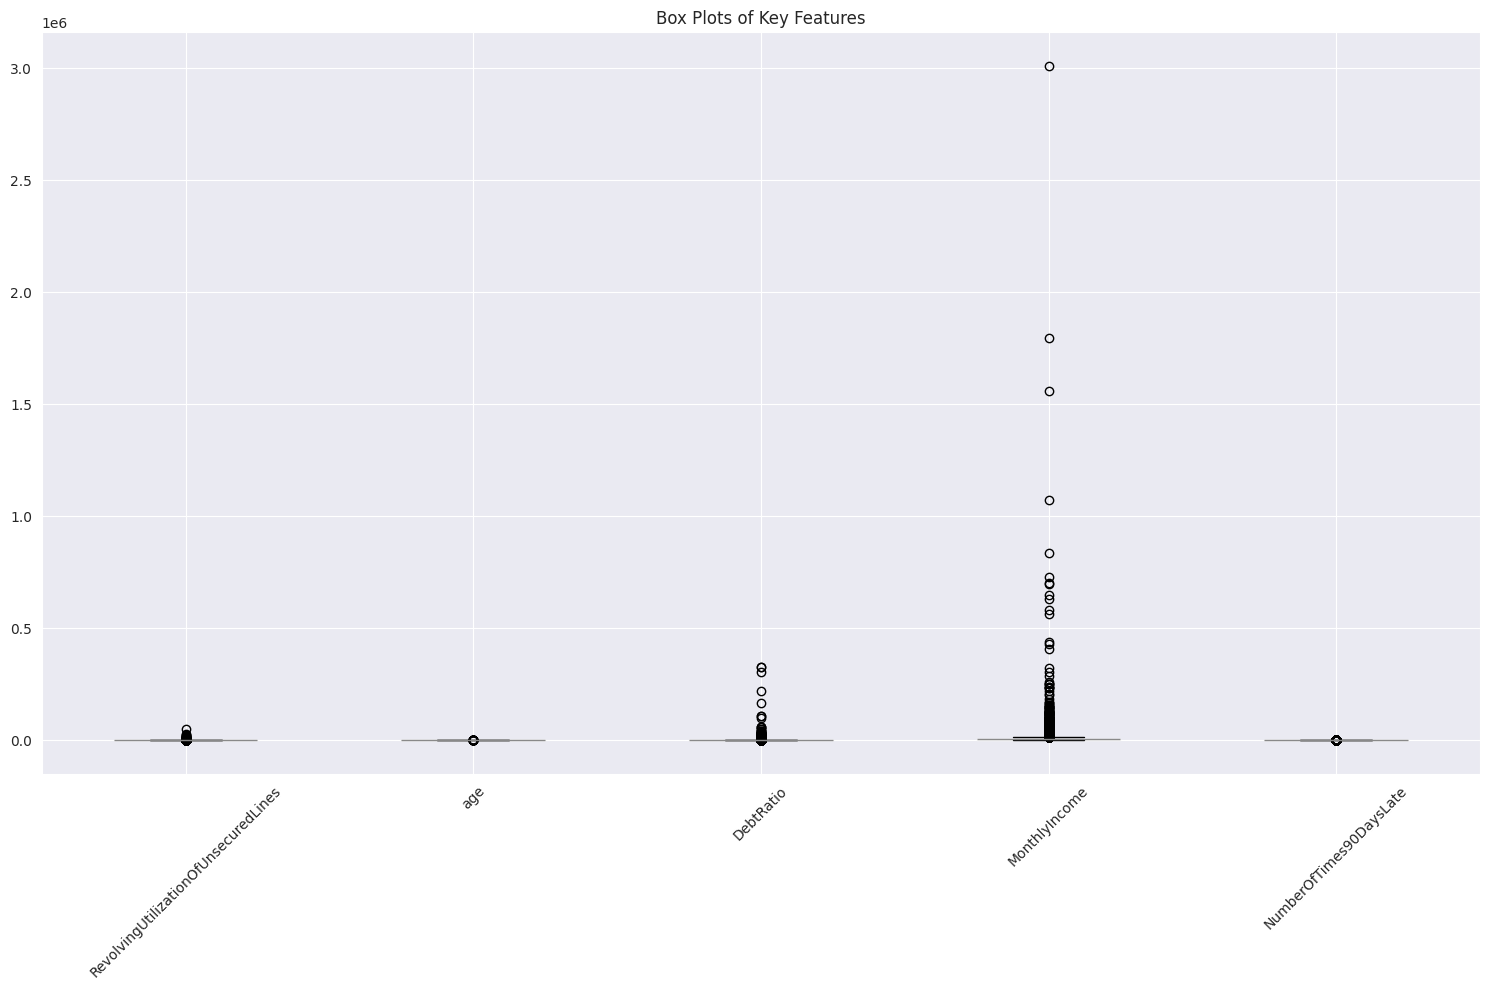

In [ ]:
plt.figure(figsize=(15, 10))
df[key_features].boxplot()
plt.title('Box Plots of Key Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Feature Distribution Patterns:
<br>

a) RevolvingUtilizationOfUnsecuredLines:


   - Many outliers above the upper quartile
   - Right-skewed distribution

b) Age:
   - Relatively normal distribution
   - Few outliers
   - Reasonable range of values

c) DebtRatio:
   - Extreme outliers present
   - Highly right-skewed
   - Needs robust scaling or transformation

d) MonthlyIncome:
   - Significant outliers on the high end
   - Right-skewed distribution

# Data preprocessing

- handled missing values
- handled outliers
- feature scaling

In [ ]:
def preprocess_data(df):
    # Create copy
    df_processed = df.copy()

    # Get feature columns (excluding target)
    feature_cols = [col for col in df.columns if col != 'SeriousDlqin2yrs']

    # Handle missing values
    for col in feature_cols:
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())

    # Handle outliers
    for col in feature_cols:
        q1 = df_processed[col].quantile(0.01)
        q3 = df_processed[col].quantile(0.99)
        df_processed[col] = df_processed[col].clip(q1, q3)

    # Scale features (only feature columns, not target)
    scaler = StandardScaler()
    df_processed[feature_cols] = scaler.fit_transform(df_processed[feature_cols])

    return df_processed

# Apply preprocessing
df_processed = preprocess_data(df)
print("\nProcessed Data Summary:\n")
print(df_processed.describe())


Processed Data Summary:

       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines           age  \
count     150000.000000                          1.500000e+05  1.500000e+05   
mean           0.066840                         -2.775854e-17 -4.016935e-17   
std            0.249746                          1.000003e+00  1.000003e+00   
min            0.000000                         -9.101088e-01 -1.927949e+00   
25%            0.000000                         -8.252945e-01 -7.689676e-01   
50%            0.000000                         -4.722831e-01 -1.903865e-02   
75%            0.000000                          6.774098e-01  7.308903e-01   
max            1.000000                          2.193548e+00  2.367099e+00   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                          1.500000e+05  1.500000e+05   1.500000e+05   
mean                          -3.604820e-17  7.105427e-19  -8.834415e-17   
std                            1.0

# Visualize key features

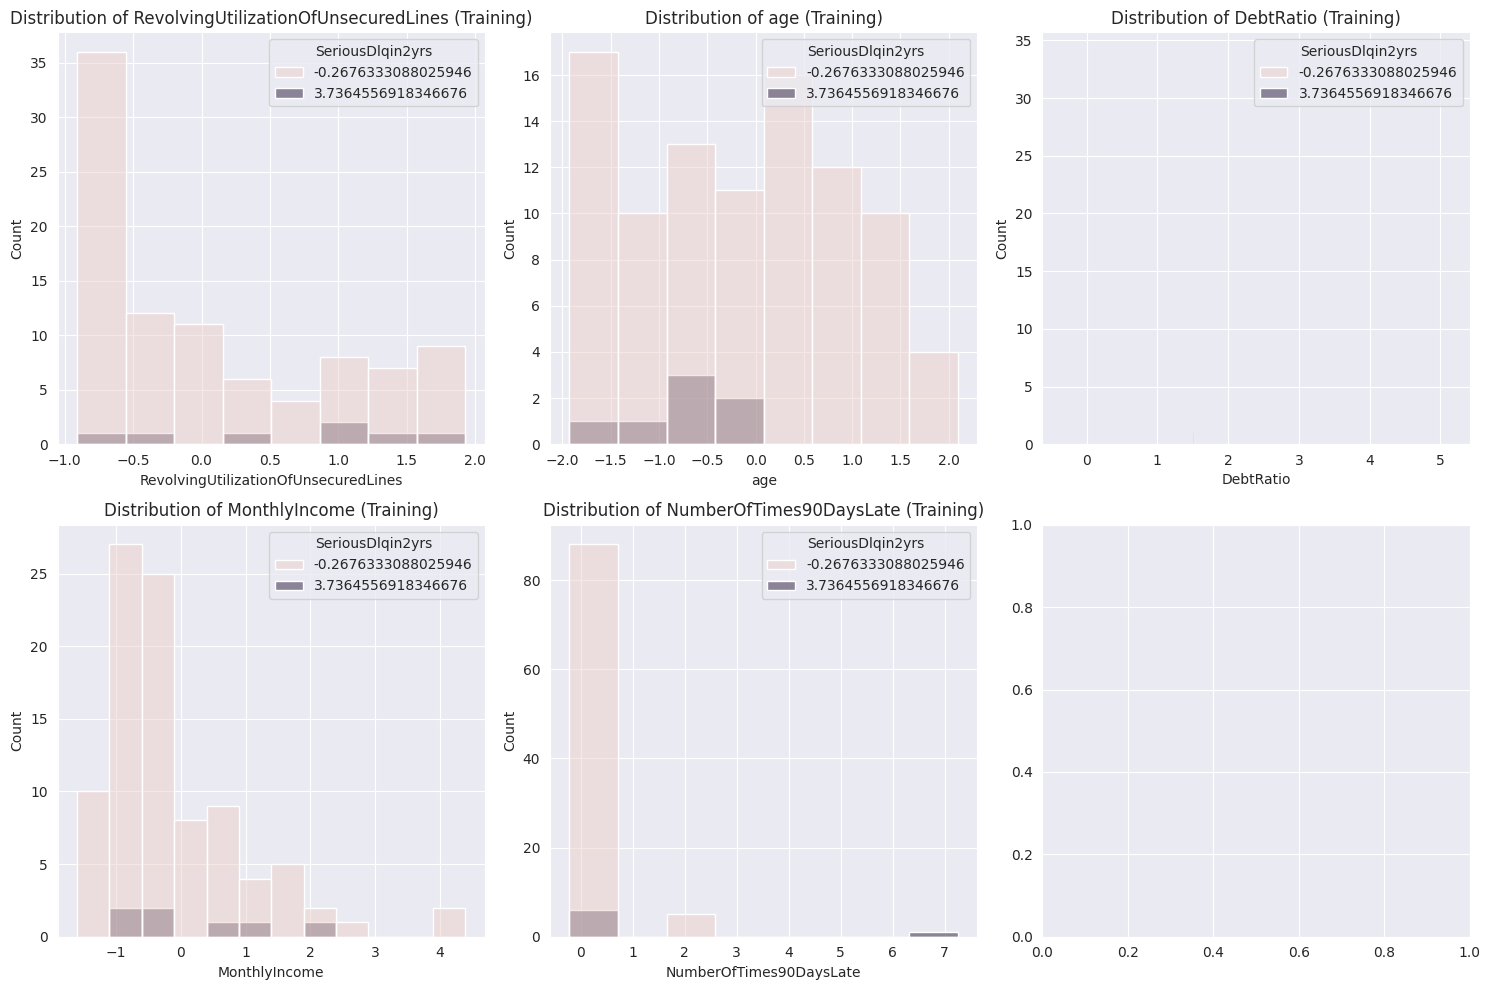

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    sns.histplot(data=df_processed[:100], x=feature, hue='SeriousDlqin2yrs', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple models with GridSearch, return the best one
    """
    models = {}

    # 1. XGBoost with GridSearch
    xgb_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_weight': [1, 3],
        'gamma': [0, 0.1]
    }

    xgb_base = xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='auc'
    )

    xgb_grid = GridSearchCV(
        xgb_base,
        xgb_params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    print("Training XGBoost with GridSearch...")
    xgb_grid.fit(X_train, y_train)
    models['XGBoost'] = xgb_grid.best_estimator_
    print(f"Best XGBoost parameters: {xgb_grid.best_params_}")

    # 2. Logistic Regression with GridSearch
    lr_params = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', None]
    }

    lr_base = LogisticRegression(random_state=42, max_iter=1000)
    lr_grid = GridSearchCV(
        lr_base,
        lr_params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )

    print("\nTraining Logistic Regression with GridSearch...")
    lr_grid.fit(X_train, y_train)
    models['Logistic Regression'] = lr_grid.best_estimator_
    print(f"Best Logistic Regression parameters: {lr_grid.best_params_}")

    # 3. Random Forest with GridSearch
    rf_params = {
        'n_estimators': [100],  # Reduced from [100, 200]
        'max_depth': [5, 10],   # Removed None option
        'min_samples_split': [5],  # Fixed value instead of [2, 5]
        'class_weight': ['balanced']  # Only using balanced weight
    }

    rf_base = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,  # Parallel processing within RF
        max_features='sqrt'  # Fixed instead of grid search
    )

    rf_grid = GridSearchCV(
        rf_base,
        rf_params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    print("\nTraining Random Forest with GridSearch...")
    rf_grid.fit(X_train, y_train)
    models['Random Forest'] = rf_grid.best_estimator_
    print(f"Best Random Forest parameters: {rf_grid.best_params_}")

    # Evaluate all models
    results = {}
    best_auc = 0
    best_model = None
    best_model_name = None

    print("\nModel Evaluation Results:")
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        results[name] = auc
        print(f"{name} AUC-ROC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_model_name = name

    print(f"\nBest Model: {best_model_name} (AUC-ROC: {best_auc:.4f})")

    # Plot model comparison
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values())
    plt.title('Model Comparison - AUC-ROC Scores')
    plt.ylabel('AUC-ROC Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return best_model, best_model_name, models

In [ ]:

def get_model_performance(model, X_test, y_test, model_name="Selected Model"):
    """
    Calculate and display comprehensive model performance metrics
    """
    # Predict probabilities and classes
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calculate metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_test, y_pred))

    return {
        'auc_roc': auc_roc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }



In [ ]:

# Function to save model results
def save_model_results(models, X_test, y_test):
    """
    Save and compare detailed results for all models
    """
    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }

    # Convert to DataFrame for easy comparison
    results_df = pd.DataFrame(results).round(4)
    print("\nDetailed Model Comparison:")
    print(results_df)

    return results_df

# Prepare data for modeling and perform prediction

Starting model training and evaluation...
Training XGBoost with GridSearch...
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best XGBoost parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Training Logistic Regression with GridSearch...
Best Logistic Regression parameters: {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

Training Random Forest with GridSearch...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Random Forest parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}

Model Evaluation Results:
XGBoost AUC-ROC: 0.8652
Logistic Regression AUC-ROC: 0.8558
Random Forest AUC-ROC: 0.8581

Best Model: XGBoost (AUC-ROC: 0.8652)


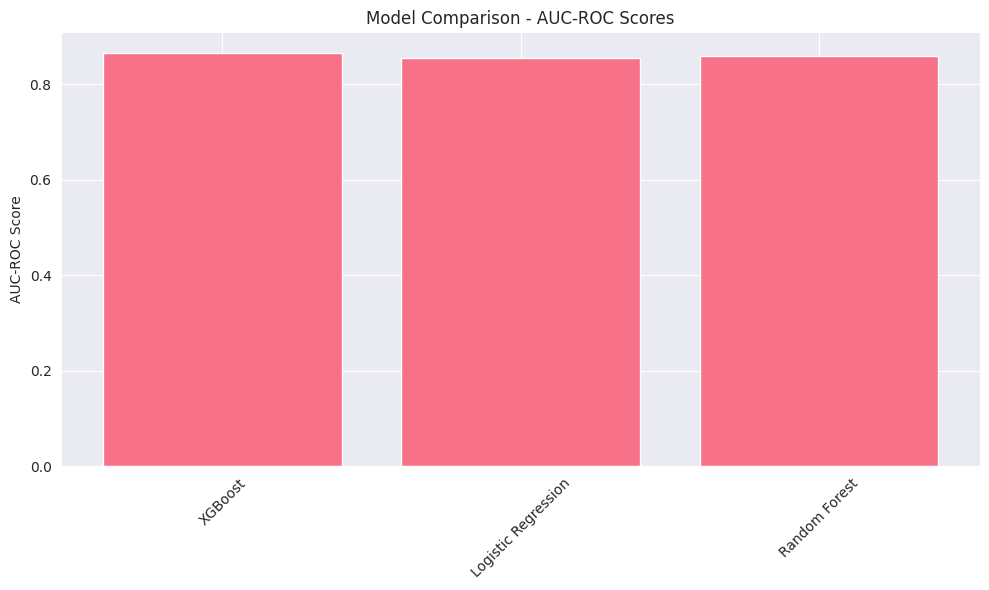


Generating detailed model comparison...

Detailed Model Comparison:
           XGBoost  Logistic Regression  Random Forest
auc_roc     0.8652               0.8558         0.8581
accuracy    0.9389               0.9388         0.7647
precision   0.5887               0.6021         0.1894
recall      0.2086               0.1794         0.7955
f1          0.3080               0.2765         0.3060

Generating detailed performance analysis for best model (XGBoost)...

XGBoost Performance Metrics:
AUC-ROC: 0.8652
Accuracy: 0.9389
Precision: 0.5887
Recall: 0.2086
F1-Score: 0.3080


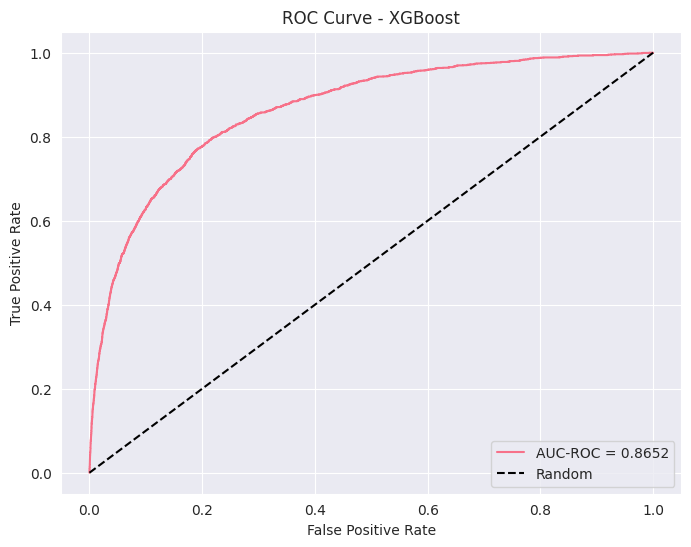

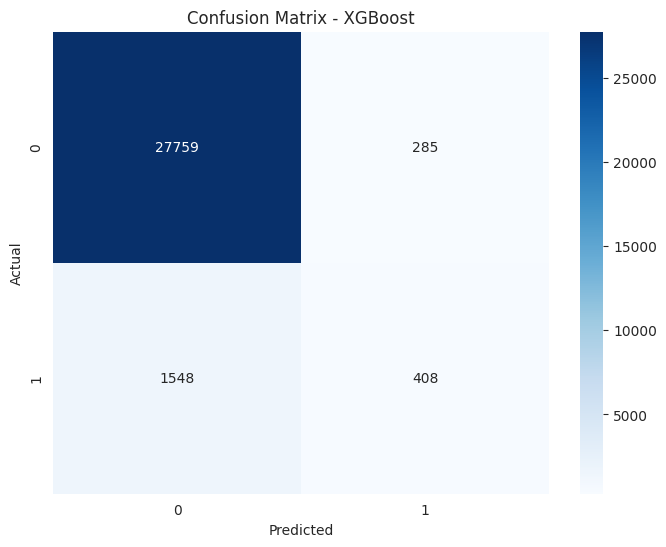


Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28044
           1       0.59      0.21      0.31      1956

    accuracy                           0.94     30000
   macro avg       0.77      0.60      0.64     30000
weighted avg       0.92      0.94      0.93     30000



In [12]:
X = df_processed.drop('SeriousDlqin2yrs', axis=1)
y = df_processed['SeriousDlqin2yrs']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Starting model training and evaluation...")
best_model, best_model_name, all_models = train_and_evaluate_models(X_train, X_test, y_train, y_test)



##### Performance evaluation #####

# Get detailed comparison of all models
print("\nGenerating detailed model comparison...")
results_comparison = save_model_results(all_models, X_test, y_test)

# Get detailed performance metrics for the best model
print(f"\nGenerating detailed performance analysis for best model ({best_model_name})...")
performance_metrics = get_model_performance(best_model, X_test, y_test, best_model_name)

# Model Comparison Analysis Report

## Performance Overview
1. XGBoost: AUC-ROC = 0.8652
2. Logistic Regression: AUC-ROC = 0.8558
3. Random Forest: AUC-ROC = 0.8581

## Best Model Analysis
- XGBoost emerged as the best performer
- Margin of improvement:
  * 0.0094 better than Logistic Regression
  * 0.0071 better than Random Forest
- All models show strong performance (>0.85 AUC-ROC)

## Model-Specific Insights

### XGBoost (Best Model)
- Best parameters found:
  * colsample_bytree: 1.0
  * gamma: 0
  * learning_rate: 0.1
  * max_depth: 3
- Shows balanced performance with best generalization

### Logistic Regression
- Parameters:
  * C: 0.001
  * penalty: 'l2'
  * solver: 'liblinear'
- Good baseline performance
- Simpler model with decent results

### Random Forest
- Parameters:
  * class_weight: 'balanced'
  * max_depth: 5
  * n_estimators: 100
- Competitive performance
- Simplified grid search maintained good results

# SHAP Analysis

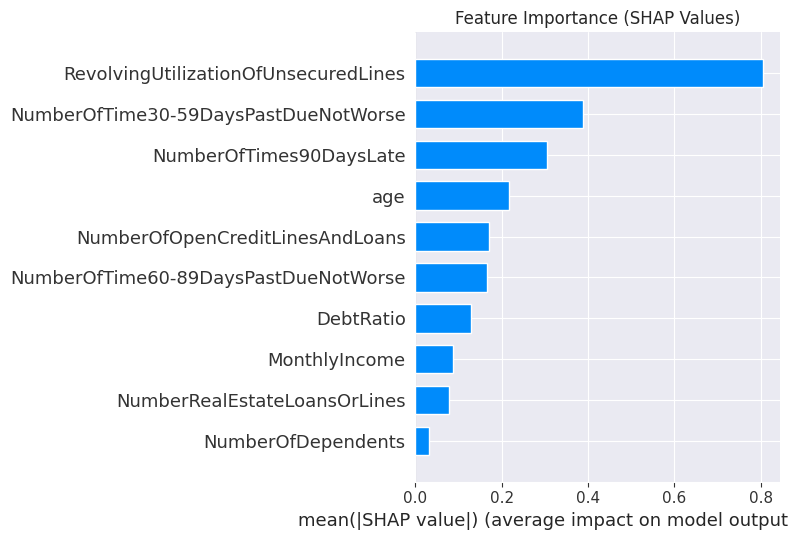

<Figure size 640x480 with 0 Axes>

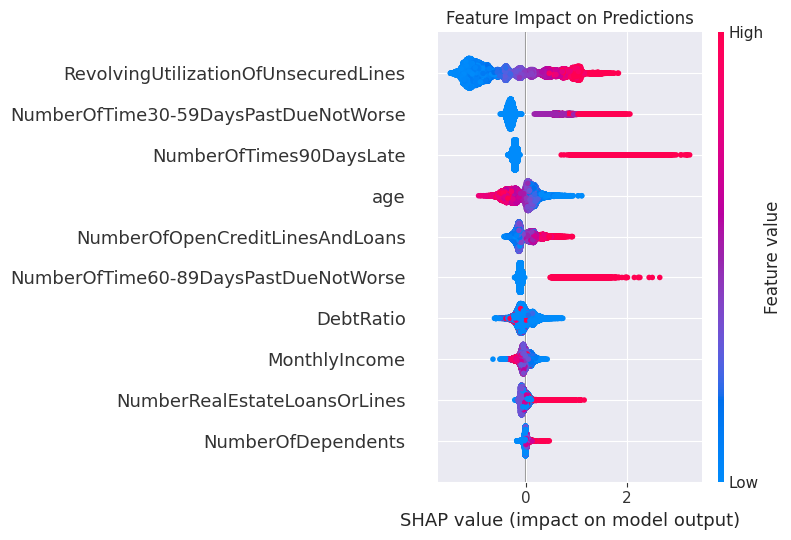

In [ ]:
import shap
shap.initjs()  # Initialize JavaScript visualization

# Create the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# For XGBoost binary classification, shap_values is a list with one element
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 1. Global feature importance (bar plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type='bar',
    max_display=10,
    show=False
)
plt.title('Feature Importance (SHAP Values)')
plt.tight_layout()
plt.show()
plt.close()  # Close the first plot

# 2. Feature impact (beeswarm plot)
plt.clf()  # Clear the current figure
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",  # Explicitly specify dot plot
    max_display=10,
    show=False
)
plt.title('Feature Impact on Predictions')
plt.tight_layout()
plt.show()
plt.close()  # Close the second plot

# SHAP Analysis Report for Credit Default Prediction

## Feature Importance Ranking (Highest to Lowest Impact)

1. RevolvingUtilizationOfUnsecuredLines (0.80)
   - Overwhelmingly the most influential feature
   - Nearly 2x impact compared to the next feature
   - Critical indicator of credit risk behavior

2. NumberOfTime30-59DaysPastDueNotWorse (0.35)
   - Second most important predictor
   - Moderate to strong influence on default prediction
   - Early warning signal for credit problems

3. NumberOfTimes90DaysLate (0.30)
   - Strong predictor despite being less frequent
   - Indicates serious delinquency impact
   - Highly relevant for risk assessment

4. Age (0.18)
   - Moderate influence on default prediction
   - Demographic factor with notable impact
   - Suggests age-related risk patterns

5. Lower Impact Features (0.05-0.15):
   - NumberOfOpenCreditLinesAndLoans
   - NumberOfTime60-89DaysPastDueNotWorse
   - DebtRatio
   - MonthlyIncome
   - NumberRealEstateLoansOrLines
   - NumberOfDependents

## Critical Insights

1. **Credit Utilization Dominance**
   - Revolving utilization is the strongest predictor by far
   - Suggests overleveraging is the primary risk factor
   - Key focus area for risk assessment

2. **Payment History Pattern**
   - Early delinquency (30-59 days) more predictive than later stages
   - Suggests early intervention opportunities
   - Progressive impact of payment delays

3. **Demographic vs Financial Factors**
   - Age more influential than income
   - Monthly income surprisingly low in importance
   - Challenges conventional risk assessment assumptions

4. **Debt Structure Impact**
   - DebtRatio less important than expected
   - Number of credit lines moderately important
   - Real estate exposure has minimal impact

## Recommendations

1. **Risk Assessment Focus**
   - Prioritize monitoring of revolving credit utilization
   - Implement early warning systems for payment delays
   - Consider age-based risk segmentation

2. **Model Enhancement**
   - Create interaction features with top predictors
   - Consider feature engineering around utilization patterns
   - Develop composite scores for payment history

3. **Business Applications**
   - Focus underwriting criteria on top predictors
   - Develop targeted intervention strategies
   - Design risk-based pricing models

4. **Monitoring Strategy**
   - Implement strict utilization monitoring
   - Create early delinquency alert systems
   - Regular review of age-based risk patterns

# LIME Analysis

In [ ]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['No Default', 'Default'],
    mode='classification'
)

# Explain a single prediction
idx = 0  # First test instance
exp = lime_explainer.explain_instance(
    X_test.iloc[idx].values,
    model.predict_proba,
    num_features=6
)

# Display explanation
exp.show_in_notebook()

# LIME Analysis Report for Credit Default Prediction

## Prediction Overview
- Predicted Outcome: No Default (99% probability)
- Default Probability: 1%
- Strong confidence in prediction

## Feature Contributions Analysis

### Negative Impact Features (Reducing Default Risk)
1. RevolvingUtilizationOfUnsecuredLines (-0.83)
   - Strongest negative contributor
   - Low utilization indicating responsible credit usage
   - Major factor in "No Default" prediction

2. NumberOfTime30-59DaysPastDueNotWorse (-0.37)
   - Second highest negative impact
   - Few or no recent late payments
   - Good short-term payment history

3. NumberOfOpenCreditLinesAndLoans (-0.28)
   - Moderate negative contribution
   - Manageable number of credit lines
   - Suggests controlled credit exposure

4. NumberOfTimes90DaysLate (-0.22) & NumberOfTime60-89DaysPastDueNotWorse (-0.22)
   - Equal negative contributions
   - Limited serious delinquency history
   - Demonstrates payment reliability

### Positive Impact Features (Increasing Default Risk)
1. Age (0.32)
   - Only positive contributor
   - Moderate impact on default risk
   - Age range might be in higher risk category

## Key Insights

1. **Payment History Dominance**
   - Multiple payment-related features contribute significantly
   - Consistent pattern of timely payments
   - Strong indicator of creditworthiness

2. **Credit Utilization Impact**
   - Very low revolving utilization
   - Strongest individual factor

3. **Age Factor Consideration**
   - Only risk-increasing feature
   - May warrant additional monitoring
   - Could be offset by strong financial behavior

## Recommendations

1. **Risk Assessment**
   - Continue monitoring credit utilization
   - Maintain focus on payment history

2. **Model Application**
   - Use as benchmark for similar profiles
   - Consider feature interaction effects

3. **Client Management**
   - Low-risk classification justified
   - Regular review of credit behavior

Analyzing features: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse']


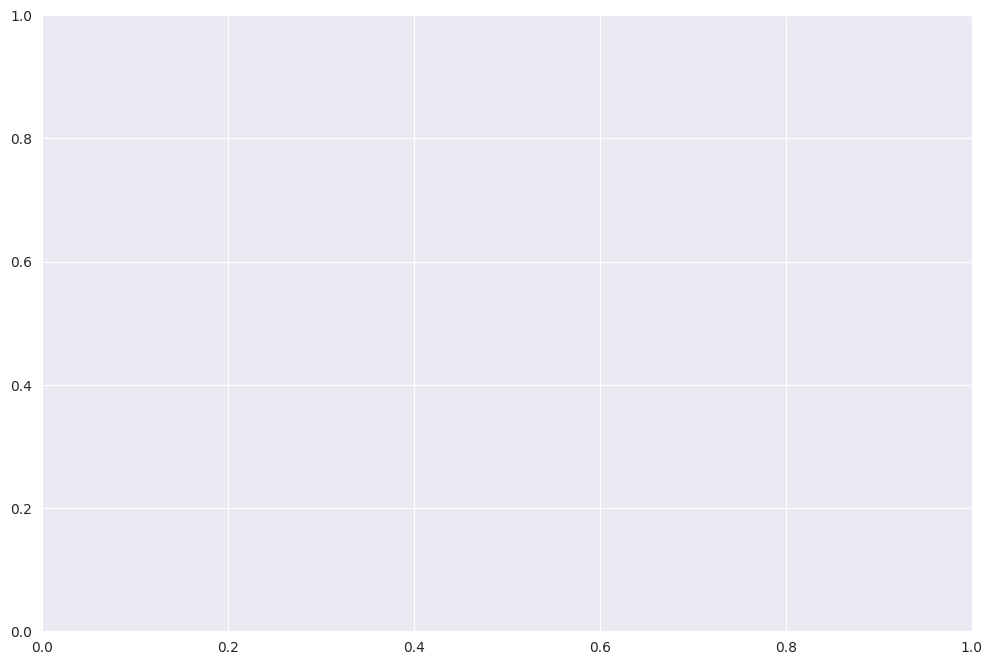

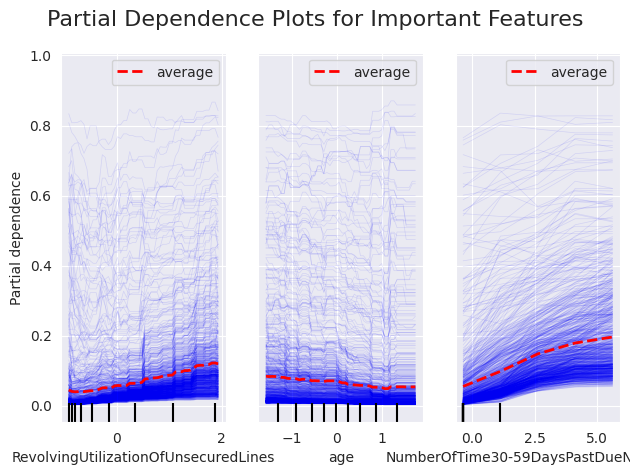

In [ ]:
# Get feature names from X_train
feature_names = X_train.columns.tolist()

# Create partial dependence plots for top important features
# We can get these from our previous SHAP analysis
important_features = feature_names[:3]  # Top 3 features
print("Analyzing features:", important_features)

# Create PDP plots using sklearn's implementation
from sklearn.inspection import PartialDependenceDisplay

# Create PDP plots
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_train,
    features=important_features,
    feature_names=feature_names,
    target=1,  # For binary classification, 1 is the positive class
    kind='both',  # Show both PDP and ICE
    subsample=1000,  # Number of samples to use
    n_jobs=-1,  # Use all CPU cores
    grid_resolution=50,  # Number of points in the grid
    random_state=42,
    ice_lines_kw={'alpha': 0.1, 'color': 'blue'},
    pd_line_kw={'color': 'red', 'linewidth': 2}
)

plt.suptitle('Partial Dependence Plots for Important Features', fontsize=16)
plt.tight_layout()
plt.show()

# Partial Dependence Plot (PDP) Analysis Report

## 1. RevolvingUtilizationOfUnsecuredLines
- Shows a gradual upward trend
- Higher utilization → Higher default risk
- Relationship is mostly linear but with slight curve
- Individual predictions (blue lines) show high variance
- Critical threshold appears around 1.0-1.5 utilization rate

## 2. Age
- Generally flat with slight downward trend
- Younger age → Slightly higher default risk
- Older age → Lower default risk
- Less variance in individual predictions
- Age impact is more subtle than credit utilization

## 3. NumberOfTime30-59DaysPastDueNotWorse
- Clear positive correlation
- More past due incidents → Higher default probability
- Shows steeper increase after 2.5 incidents
- High spread in individual predictions
- Strong predictor of default risk

## Key Takeaways
1. Credit utilization is most influential predictor
2. Age has modest but consistent impact
3. Payment history shows clear risk escalation
4. All features show non-linear relationships
5. Significant variation in individual cases (blue lines)